## Competition

[Competition](https://www.kaggle.com/t/b2a5dce8f98c413da4a03db11577fe6c)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

SEED = 42

In [3]:
train_df = pd.read_csv('data/train.csv')["text"]
train_df.head()

0    they hope the president elect stands up to his...
1    it's the latest in a string of test launches o...
2    the need to control an undesirable situation b...
3                                                  NaN
4    personal intelligence is new kid on the block ...
Name: text, dtype: object

In [4]:
train_df.isna().sum()

18000

In [5]:
train_df[train_df.isna()].head()

3     NaN
7     NaN
16    NaN
19    NaN
21    NaN
Name: text, dtype: object

In [6]:
train_df = train_df.dropna()

In [7]:
test_df = pd.read_csv("data/test.csv")["sample"]
test_df.head()

0                    what if in doing so we won't just
1              it should have been a glorious week for
2       a few protesters who refused to leave remained
3    scientists didn't know if humans played that game
4                here are five ways to get some beauty
Name: sample, dtype: object

In [8]:
test_df.isna().sum()

0

In [9]:
train_text_lens = []


def count_len(text: str):
    train_text_lens.append(len(text.split()))
    return text


train_df = train_df.apply(count_len)

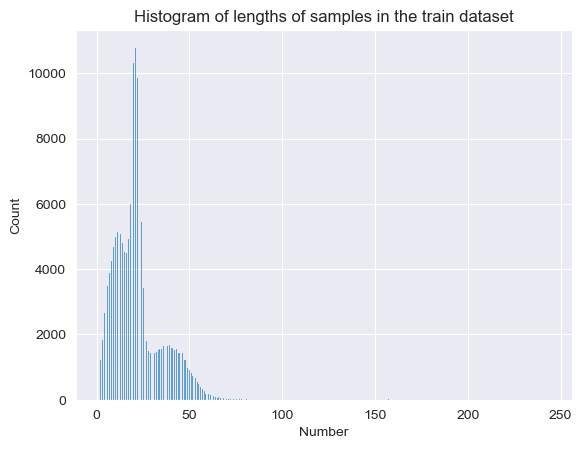

In [10]:
sns.histplot(train_text_lens)
plt.xlabel("Number")
plt.title("Histogram of lengths of samples in the train dataset")
plt.show()

In [11]:
max(set(train_text_lens), key=train_text_lens.count)

21

In [12]:
max(set(train_text_lens)), min(set(train_text_lens))

(244, 1)

In [13]:
test_text_lens = []


def count_len(text_row: str):
    test_text_lens.append(len(text_row.split()))
    return text_row


test_df = test_df.apply(count_len)

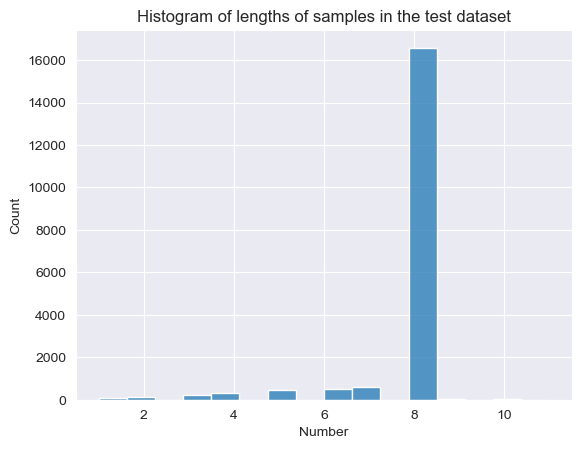

In [14]:
sns.histplot(test_text_lens)
plt.xlabel("Number")
plt.title("Histogram of lengths of samples in the test dataset")
plt.show()

In [15]:
max(set(test_text_lens), key=test_text_lens.count)

8

In [16]:
max(set(test_text_lens)), min(set(test_text_lens))

(11, 1)

Test text is not longer than 11 words. Meanwhile, there are lots of inputs sentences containing much more words. Thus, I'd split the train data up to 15 words in each to regularise length of train sentences.
Because I have no idea if it's better to remove some examples where we have lesser than 2 words in train data (i.e. the model might generate the initial word which is not helpful for test data), I'd create 2 train datasets: with these examples and without them.
Which one do I need to use for better results? I would test that using not fine_tuned model.

In [17]:
from typing import List, Tuple
from string import punctuation as punct
STR_LEN = 15

In [18]:
text_split = train_df.tolist()  # Every string will be split to some strings with 15 words at most each. The last new string will be added to the list too.
text_cut = train_df.tolist()  # Every string will be split to some strings with 15 words at most each. The last new string  with less than 2 words will be removed.

In [19]:
def prerocess(text_list: List[str], last_stay: bool = False) -> Tuple[List[str], List[str]]:
    global STR_LEN
    input_list = []
    output_list = []
    for text in text_list:
        for p in punct:
            text = text.replace(p, f" {p} ")
        words = text.split()
        for str_i in range(0, len(words), STR_LEN + 1):
            single_sample = words[str_i: str_i + STR_LEN + 1]
            if not last_stay and len(single_sample) < 3:
                continue
            input_list.append(single_sample[:-1])
            output_list.append(single_sample[-1])
            
    return input_list, output_list

In [20]:
text_split_input, text_split_output = prerocess(text_split, True)
text_cut_input, text_cut_output = prerocess(text_cut)

In [21]:
print("Example with splitting")
print("Inputs:", *text_split_input[15:20], "Outputs:", text_split_output[15:20], "\n", sep="\n")
print("Example with cutting")
print("Inputs:", *text_cut_input[15:20], "Outputs:", text_cut_output[15:20], "\n", sep="\n")

Example with splitting
Inputs:
['you', 'don', "'", 't', 'see', 'at', 'first']
['during', 'an', 'appearance', 'on', 'huffpost', 'live', 'monday', 'style', 'me', 'pretty', 'founder', 'abby', 'larson', 'offered', 'her']
['on', 'glamming', 'up', 'a']
['the', 'fatalities', 'include', 'an', '18', 'year', 'old', 'and', '10', 'year', 'old', 'a', 'motive', 'for', 'the']
['has', 'yet', 'to', 'be']
Outputs:
['glance', 'advice', 'budget', 'attack', 'determined']


Example with cutting
Inputs:
['during', 'an', 'appearance', 'on', 'huffpost', 'live', 'monday', 'style', 'me', 'pretty', 'founder', 'abby', 'larson', 'offered', 'her']
['on', 'glamming', 'up', 'a']
['the', 'fatalities', 'include', 'an', '18', 'year', 'old', 'and', '10', 'year', 'old', 'a', 'motive', 'for', 'the']
['has', 'yet', 'to', 'be']
['earth', 'accounting', 'is', 'the', 'effort', 'of', 'a', 'dedicated', 'but', 'as', 'yet', 'small', 'group', 'to', 'create']
Outputs:
['advice', 'budget', 'attack', 'determined', 'this']


In [22]:
import torch
torch.random.manual_seed(SEED)

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vocab

MAX_TOKENS = 50000


def create_vocab_and_tokens(input_text: List[str], output_text: List[str]) -> Tuple[Vocab, List[torch.LongTensor], List[int]]:
    tokenizer = get_tokenizer("basic_english")
    train_tokens = [tokenizer(" ".join(list_in + [list_out])) for list_in, list_out in zip(input_text, output_text)]
    vocab = build_vocab_from_iterator(train_tokens, specials=["<unk>"])
    train_in = []
    train_out = []
    
    for list_in, list_out in zip(input_text, output_text):
        list_in = [vocab[word] for word in list_in] + [0] * (STR_LEN - len(list_in))        
        train_in.append(torch.tensor(list_in, dtype=torch.long))
        train_out.append(vocab[list_out])
    
    return vocab, train_in, train_out

In [23]:
vocab_split, input_split, output_split = create_vocab_and_tokens(text_split_input, text_split_output)
vocab_cut, input_cut, output_cut = create_vocab_and_tokens(text_cut_input, text_cut_output)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
train_x_split, val_x_split, train_y_split, val_y_split = train_test_split(input_split, output_split, test_size=0.2, random_state=SEED)
train_x_cut, val_x_cut, train_y_cut, val_y_cut = train_test_split(input_cut, output_cut, test_size=0.2, random_state=SEED)

In [26]:
import torch.nn as nn
from torch.nn import functional as F

In [27]:
class NGramLM(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, drop_prob: float):
        super(NGramLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim  * STR_LEN, hidden_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(drop_prob)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensors):
        out = self.embedding(input_tensors)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.dropout(self.batch_norm(out))
        return self.softmax(self.fc2(out))

In [28]:
from nltk.translate.bleu_score import sentence_bleu
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
def train_model(model: NGramLM, train_in: List[torch.LongTensor], train_out: List[int], optimizer: optim.Optimizer, loss_fn, batch_size: int, device: torch.device, info: bool = True):
    train_data = DataLoader(list(zip(train_in, train_out)), batch_size, True)
    if info:
        train_data = tqdm(train_data, "Model training", len(train_data))
    model.train()
    
    total_loss = 0
    for x, y in train_data:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if info:
        print(f"Total loss: {total_loss}")
    torch.cuda.empty_cache()
    return total_loss


def validate_model(model: NGramLM, val_in: List[torch.LongTensor], val_out: List[int], vocab: Vocab, batch_size: int, device: torch.device, info: bool = True):
    val_data = DataLoader(list(zip(val_in, val_out)), batch_size)
    if info:
        val_data = tqdm(val_data, "Model validation", len(val_data))
        
    total_bleu_score = 0
    model.eval()
    
    for batch_in, batch_out in val_data:
        batch_in, batch_out = batch_in.to(device), batch_out.to(device)
        pred = model(batch_in)
        pred_ids = torch.argmax(pred, dim=1)
        pred_words = vocab.lookup_tokens(pred_ids.tolist())
        ref_words = vocab.lookup_tokens(batch_out.tolist())

        batch_sentences = []
        batch_references = []
        for str_i in range(len(batch_in)):
            start_words = vocab.lookup_tokens(batch_in[str_i].tolist())
            batch_sentences.append(start_words + [pred_words[str_i]])
            batch_references.append(start_words + [ref_words[str_i]])

        batch_bleu_scores = [sentence_bleu([ref], pred) for ref, pred in zip(batch_references, batch_sentences)]
        total_bleu_score += sum(batch_bleu_scores) / len(batch_bleu_scores)
    
    if info:
        print(f"Average BLEU Score: {total_bleu_score / len(val_data)}")
    return total_bleu_score / len(val_data)


def train_validate_model(model: NGramLM, train_in: List[torch.LongTensor], train_out: List[int], val_in: List[torch.LongTensor], val_out: List[int], vocab: Vocab, optimizer: optim.Optimizer, loss_fn, device: torch.device, batch_size: int, epochs: int, info: bool = True):
    loss = []
    score = []
    for epoch in range(epochs):
        if info:
            print(f"Epoch {epoch + 1}:")
        loss.append(train_model(model, train_in, train_out, optimizer, loss_fn, batch_size, device, info))
        score.append(validate_model(model, val_in, val_out, vocab, batch_size, device, info))
    
    return loss, score

In [30]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 4096
DROP_PROB = 0.4
LR = 0.01
BATCH_SIZE = 128
EPOCHS = 3

In [30]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 3072
DROP_PROB = 0.4
LR = 0.1
BATCH_SIZE = 128
EPOCHS = 3

print("Train and validate on full data")
ngram_split = NGramLM(len(vocab_split), EMBEDDING_DIM, HIDDEN_DIM, DROP_PROB).to(DEVICE)
optimizer_split = optim.Adam(ngram_split.parameters(), LR)
loss_fn_split = nn.NLLLoss()
_, split_score = train_validate_model(ngram_split, train_x_split, train_y_split, val_x_split, val_y_split, vocab_split, optimizer_split, loss_fn_split, DEVICE, BATCH_SIZE, EPOCHS)

print("Train and validate on cut data")
ngram_cut = NGramLM(len(vocab_cut), EMBEDDING_DIM, HIDDEN_DIM, DROP_PROB).to(DEVICE)
optimizer_cut = optim.Adam(ngram_cut.parameters(), LR)
loss_fn_cut = nn.NLLLoss()
_, cut_score = train_validate_model(ngram_cut, train_x_cut, train_y_cut, val_x_cut, val_y_cut, vocab_cut, optimizer_cut, loss_fn_cut, DEVICE, BATCH_SIZE, EPOCHS)

print("Train on cut data, validate on full data")
ngram_cut_split = NGramLM(len(vocab_split), EMBEDDING_DIM, HIDDEN_DIM, DROP_PROB).to(DEVICE)
optimizer_cut_split = optim.Adam(ngram_split.parameters(), LR)
loss_fn_cut_split = nn.NLLLoss()
_, merge_score = train_validate_model(ngram_cut_split, train_x_cut, train_y_cut, val_x_split, val_y_split, vocab_split, optimizer_cut_split, loss_fn_cut_split, DEVICE, BATCH_SIZE, EPOCHS)

print("\n\nAverage of best 5 scores in training")
print(f"Split data: {sum(sorted(split_score, reverse=True)[:5]) / 5}")
print(f"Cut data: {sum(sorted(cut_score, reverse=True)[:5]) / 5}")
print(f"Merged data: {sum(sorted(merge_score, reverse=True)[:5]) / 5}")

Train and validate on full data
Epoch 1:


Model training: 100%|██████████| 2058/2058 [02:05<00:00, 16.39it/s]


Total loss: 271387.9749851227


Model validation: 100%|██████████| 515/515 [00:19<00:00, 26.46it/s]


Average BLEU Score: 0.9327512648311368
Epoch 2:


Model training: 100%|██████████| 2058/2058 [02:05<00:00, 16.39it/s]


Total loss: 348035.3880004883


Model validation: 100%|██████████| 515/515 [00:19<00:00, 26.57it/s]


Average BLEU Score: 0.9311401232985569
Epoch 3:


Model training: 100%|██████████| 2058/2058 [02:05<00:00, 16.37it/s]


Total loss: 402518.75941467285


Model validation: 100%|██████████| 515/515 [00:19<00:00, 26.58it/s]


Average BLEU Score: 0.9320838419044196
Train and validate on cut data
Epoch 1:


Model training: 100%|██████████| 1947/1947 [02:02<00:00, 15.95it/s]


Total loss: 251857.02425003052


Model validation: 100%|██████████| 487/487 [00:19<00:00, 24.36it/s]


Average BLEU Score: 0.9309717621384204
Epoch 2:


Model training: 100%|██████████| 1947/1947 [02:03<00:00, 15.83it/s]


Total loss: 343568.6124725342


Model validation: 100%|██████████| 487/487 [00:20<00:00, 24.07it/s]


Average BLEU Score: 0.9316374816946474
Epoch 3:


Model training: 100%|██████████| 1947/1947 [02:02<00:00, 15.88it/s]


Total loss: 369437.1028289795


Model validation: 100%|██████████| 487/487 [00:20<00:00, 23.97it/s]


Average BLEU Score: 0.9320576417457103
Train on cut data, validate on full data
Epoch 1:


Model training: 100%|██████████| 1947/1947 [00:41<00:00, 47.45it/s]


Total loss: 22422.191197395325


Model validation: 100%|██████████| 515/515 [00:21<00:00, 24.08it/s]


Average BLEU Score: 0.9306048591021066
Epoch 2:


Model training: 100%|██████████| 1947/1947 [02:18<00:00, 14.11it/s]


Total loss: 22423.815982818604


Model validation: 100%|██████████| 515/515 [00:20<00:00, 25.71it/s]


Average BLEU Score: 0.9306048591021066
Epoch 3:


Model training: 100%|██████████| 1947/1947 [00:39<00:00, 49.00it/s]


Total loss: 22423.528858184814


Model validation: 100%|██████████| 515/515 [00:19<00:00, 26.43it/s]

Average BLEU Score: 0.9306048591021066


Average of best 5 scores in training
Split data: 0.5591950460068227
Cut data: 0.5589333771157556
Merged data: 0.5583629154612639


In [31]:
main_vocab = vocab_split
train_x, val_x, train_y, val_y = train_x_split, val_x_split, train_y_split, val_y_split

In [32]:
best_model = NGramLM(len(main_vocab), EMBEDDING_DIM, HIDDEN_DIM, DROP_PROB).to(DEVICE)
best_optim = optim.Adam(best_model.parameters(), LR)
best_loss_fn = nn.NLLLoss()

In [33]:
import os

if not os.listdir("models"):
    for _ in range(20):
        train_model(best_model, input_split, output_split, best_optim, best_loss_fn, BATCH_SIZE, DEVICE)
    torch.save(best_model.state_dict(), "models")

Model training: 100%|██████████| 2572/2572 [02:58<00:00, 14.39it/s]


Total loss: 23096.30429983139


Model training: 100%|██████████| 2572/2572 [03:00<00:00, 14.27it/s]


Total loss: 21014.018681049347


Model training: 100%|██████████| 2572/2572 [03:00<00:00, 14.26it/s]


Total loss: 19784.416141033173


Model training: 100%|██████████| 2572/2572 [03:00<00:00, 14.27it/s]


Total loss: 17398.30679321289


Model training: 100%|██████████| 2572/2572 [03:01<00:00, 14.20it/s]


Total loss: 14522.13338136673


Model training: 100%|██████████| 2572/2572 [03:00<00:00, 14.28it/s]


Total loss: 12728.261999607086


Model training: 100%|██████████| 2572/2572 [03:00<00:00, 14.28it/s]


Total loss: 11561.032462358475


Model training: 100%|██████████| 2572/2572 [02:59<00:00, 14.30it/s]


Total loss: 10745.0839407444


Model training: 100%|██████████| 2572/2572 [03:00<00:00, 14.27it/s]


Total loss: 10218.255128264427


Model training: 100%|██████████| 2572/2572 [03:01<00:00, 14.20it/s]


Total loss: 9794.319899439812


Model training: 100%|██████████| 2572/2572 [02:56<00:00, 14.55it/s]


Total loss: 9526.219476103783


Model training: 100%|██████████| 2572/2572 [02:58<00:00, 14.41it/s]


Total loss: 9292.058467268944


Model training: 100%|██████████| 2572/2572 [02:57<00:00, 14.51it/s]


Total loss: 9031.829261660576


Model training: 100%|██████████| 2572/2572 [02:58<00:00, 14.43it/s]


Total loss: 8915.756856679916


Model training: 100%|██████████| 2572/2572 [02:55<00:00, 14.68it/s]


Total loss: 8891.929317831993


Model training: 100%|██████████| 2572/2572 [02:57<00:00, 14.51it/s]


Total loss: 8850.432147979736


Model training: 100%|██████████| 2572/2572 [03:00<00:00, 14.22it/s]


Total loss: 8780.681767940521


Model training: 100%|██████████| 2572/2572 [03:01<00:00, 14.13it/s]


Total loss: 8739.196311593056


Model training: 100%|██████████| 2572/2572 [03:00<00:00, 14.26it/s]


Total loss: 8765.813013076782


Model training: 100%|██████████| 2572/2572 [02:54<00:00, 14.71it/s]


Total loss: 8808.762719988823


RuntimeError: File models cannot be opened.

In [35]:
torch.save(best_model.state_dict(), "models/ngram")

In [37]:
best_model.load_state_dict(torch.load("models/ngram"))
best_model.eval()

NGramLM(
  (embedding): Embedding(75272, 100)
  (fc1): Linear(in_features=1500, out_features=4096, bias=True)
  (batch_norm): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=4096, out_features=75272, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [47]:
def predict(text: str, model: NGramLM) -> List[str]:
    global main_vocab
    for p in punct:
        text = text.replace(p, f" {p} ")
    
    input_tokens = [main_vocab[word] if word in main_vocab else 0 for word in text.split()]
    input_tensor = torch.tensor([input_tokens + [0] * (STR_LEN - len(input_tokens))], dtype=torch.long, device=DEVICE)
    probs = model(input_tensor)
    word_id = torch.argmax(probs, dim=1)
    return text + f" {main_vocab.lookup_token(word_id)}"

In [48]:
predictions = []

with torch.no_grad():
    for sample in test_df:
        output = predict(sample, best_model)
        predictions.append(output)

In [51]:
ids = pd.read_csv("data/test.csv")["id"]

In [52]:
output_df = pd.DataFrame({"id": ids, "prediction": predictions})
output_df.to_csv("data/submission.csv", index=False)